In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


Original Shape:  (10459, 24)
Finished Shape:  (10328, 47)
RiskPerformance


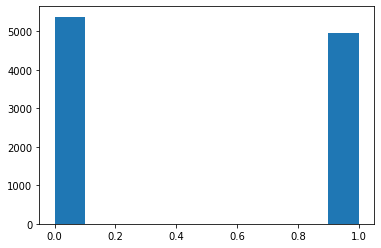

1 ExternalRiskEstimate
With missing


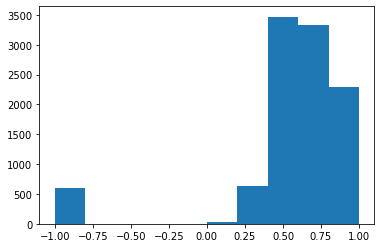

With imputed


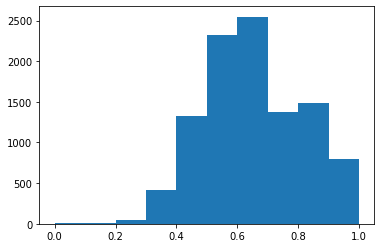

2 MSinceOldestTradeOpen
With missing


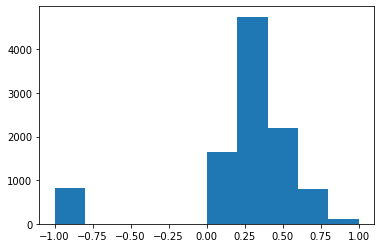

With imputed


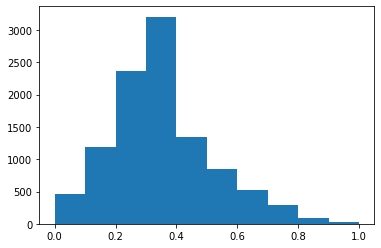

3 MSinceMostRecentTradeOpen
With missing


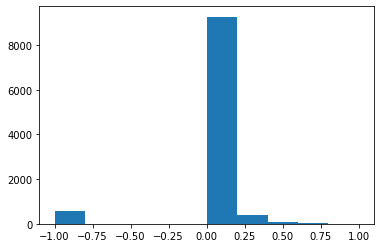

With imputed


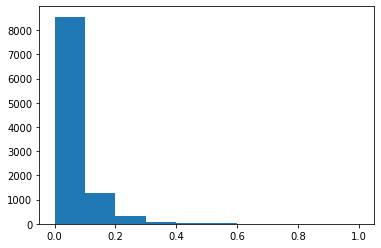

4 AverageMInFile
With missing


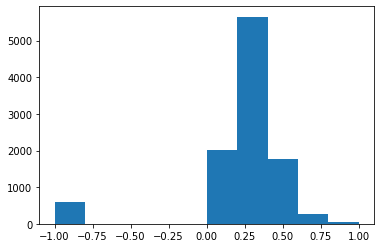

With imputed


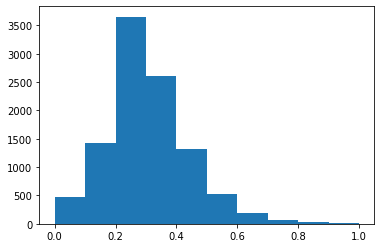

5 NumSatisfactoryTrades
With missing


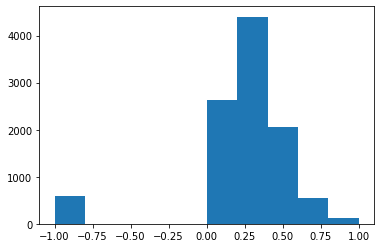

With imputed


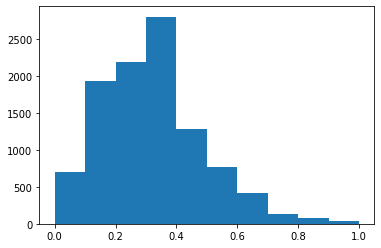

6 NumTrades60Ever2DerogPubRec
With missing


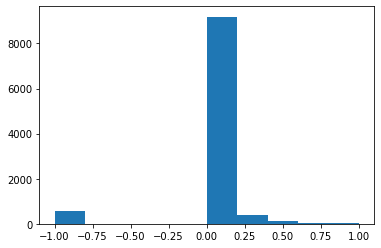

With imputed


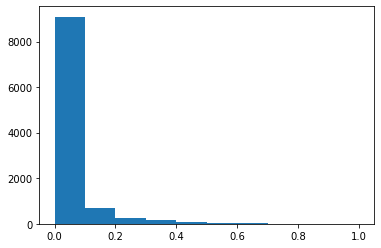

7 NumTrades90Ever2DerogPubRec
With missing


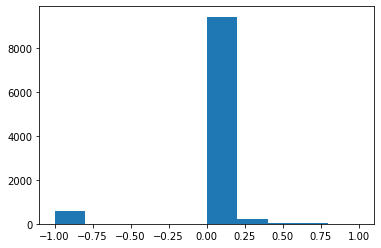

With imputed


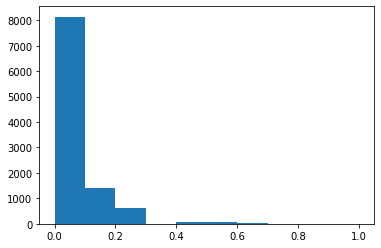

8 PercentTradesNeverDelq
With missing


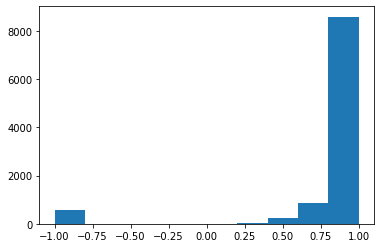

With imputed


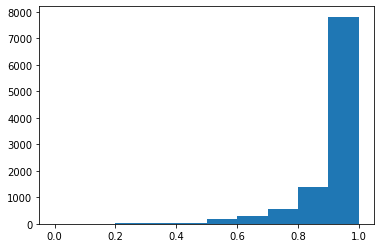

9 MSinceMostRecentDelq
With missing


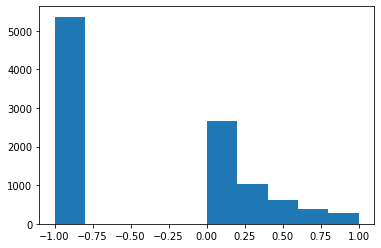

With imputed


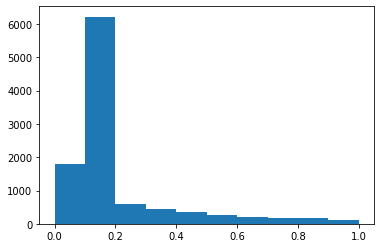

10 MaxDelq2PublicRecLast12M
With missing


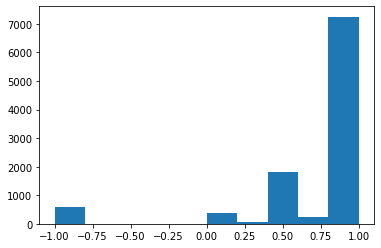

With imputed


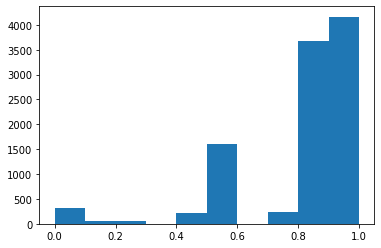

11 MaxDelqEver
With missing


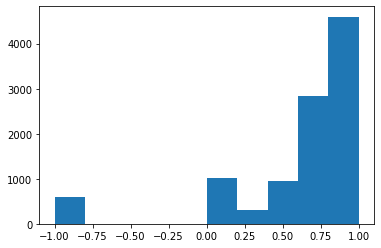

With imputed


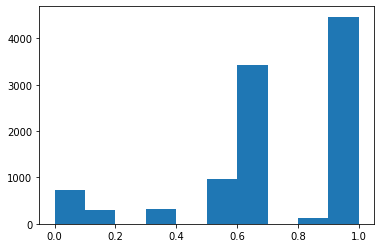

12 NumTotalTrades
With missing


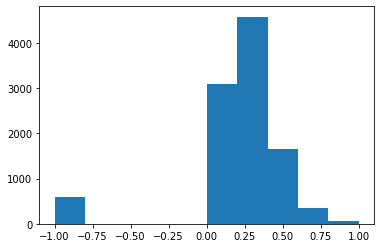

With imputed


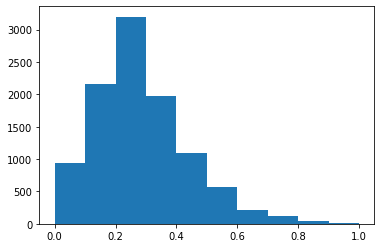

13 NumTradesOpeninLast12M
With missing


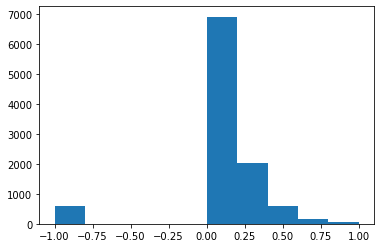

With imputed


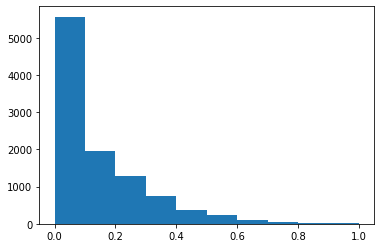

14 PercentInstallTrades
With missing


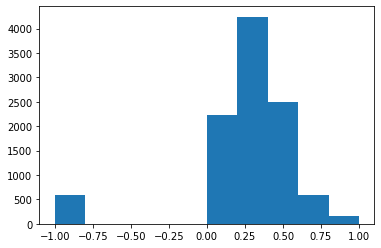

With imputed


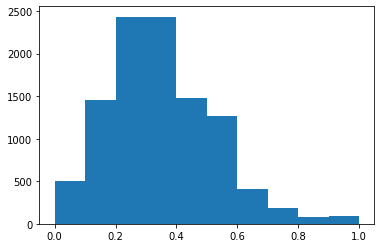

15 MSinceMostRecentInqexcl7days
With missing


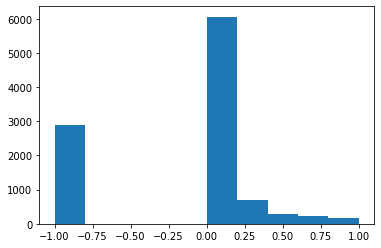

With imputed


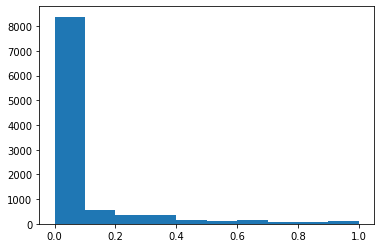

16 NumInqLast6M
With missing


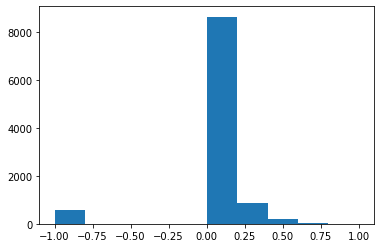

With imputed


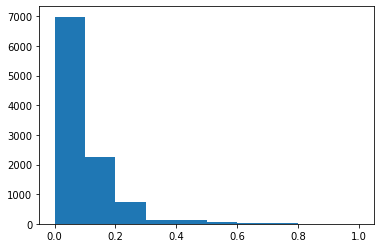

17 NumInqLast6Mexcl7days
With missing


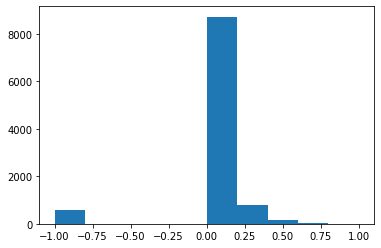

With imputed


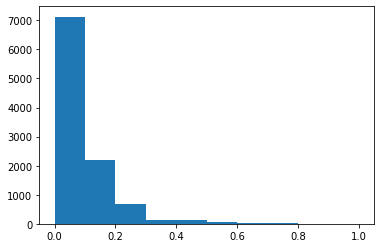

18 NetFractionRevolvingBurden
With missing


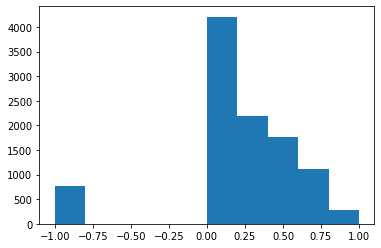

With imputed


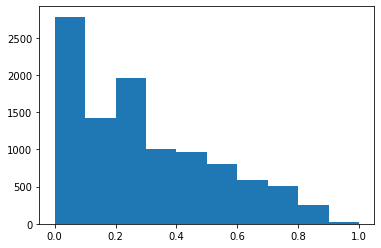

19 NetFractionInstallBurden
With missing


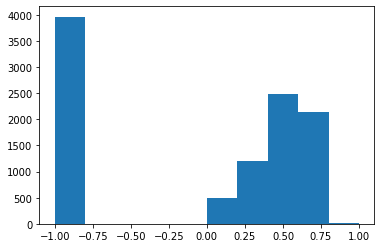

With imputed


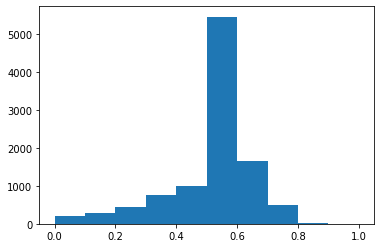

20 NumRevolvingTradesWBalance
With missing


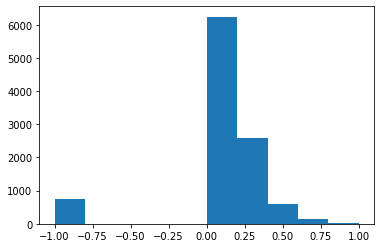

With imputed


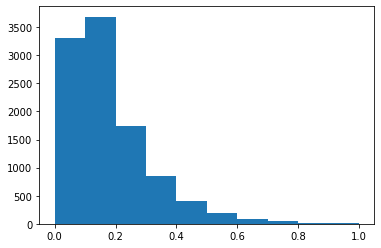

21 NumInstallTradesWBalance
With missing


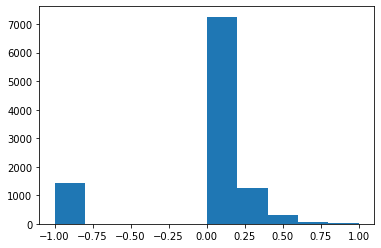

With imputed


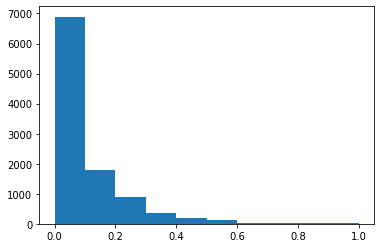

22 NumBank2NatlTradesWHighUtilization
With missing


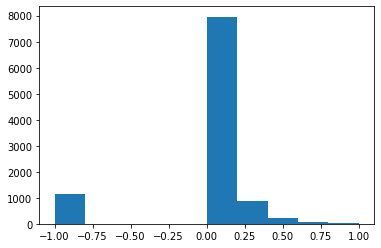

With imputed


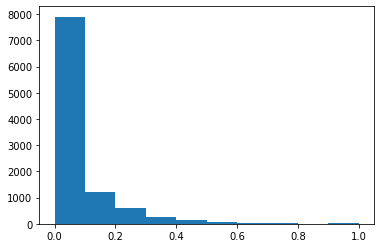

23 PercentTradesWBalance
With missing


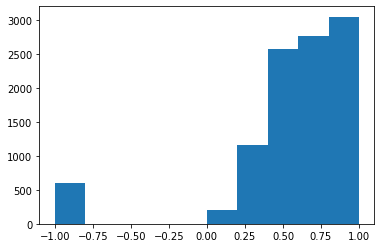

With imputed


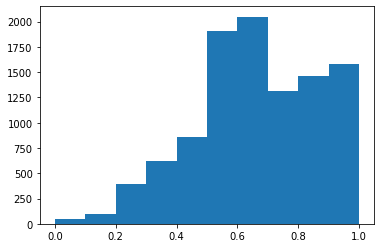

In [2]:
# Load the dataset
data = pd.read_csv("heloc_dataset_v1.csv")

colnames = list(data.columns)
d = len(colnames)

data = data.values
print("Original Shape: ", data.shape)

# Replace the labels with binary values
np.place(data, data == "Bad", 0)
np.place(data, data == "Good", 1)

# Where are the missing values?
# For now, we treat all of the general special values (-9, -8, -7) as being identical and missing
def is_missing(x, name):
    if name == "MaxDelq2PublicRecLast12M":
        values = [-9, -8, -7, 8, 9]
    elif name == "MaxDelqEver":
        values = [-9, -8, -7, 1, 9]
    else:
        values = [-9, -8, -7]
        
    out = np.zeros((len(x)))
    for i in range(len(x)):
        out[i] = x[i] in values
    out = out.astype(bool)
    return out

def replace(x, indices, v = -1):
    x_new = np.copy(x)
    x_new[indices] = v
    return x_new

# There are some individuals with extreme outliers in this dataset
# For now, we remove them
def is_not_outlier(x, threshold = 99.9):
    return np.where(x <= np.percentile(x, threshold))[0]

# Ignoring missing values (-1), set the range of the data to [0, 1]
# TODO: return the min and max values so that new points can be scaled
def scale(x):
    indices = np.where(x != -1)[0]
    x_copy = np.copy(x)
    x_indices = x_copy[indices] 
    x_indices -= np.min(x_indices)
    x_indices /= np.max(x_indices)
    x_copy[indices] = x_indices
    return x_copy  

# Impute the missing values (-1) with the median value
# We use median becuase these distributions are skewed
def impute(x):
    indices_missing = np.where(x == -1)[0]
    indices = np.where(x != -1)[0]
    x_copy = np.copy(x)
    x_indices = x_copy[indices]
    value = np.median(x_indices)
    x_copy[indices_missing] = value
    return x_copy, 1 * (x == -1)

# Simplify the missing values and find the outliers for each feature
data_new = np.copy(data)
indices = []
for i in range(d):
    name = colnames[i]
    x = data[:, i]
    
    missing = is_missing(x, name)
    x_new = replace(x, missing)
    data_new[:, i] = x_new

    not_outlier = is_not_outlier(x_new)
    indices.append(not_outlier)

# Remove outliers from the datset
intersect = indices[0]
for i in range(1, len(indices)):
    intersect = np.intersect1d(intersect, indices[i], assume_unique = True)   
data_new = data_new[intersect, :]

# Scale the dataset
for i in range(d):
    data_new[:, i] = scale(data_new[:, i])
    
# Impute the missing values TODO: add an imputation flag
data_imputed = np.zeros((data_new.shape[0], 2 * d - 1))

data_imputed[:, 0] = data_new[:, 0]
for i in range(1, d):
    x = data_new[:, i]
    x_imputed, x_missing = impute(x)
    data_imputed[:, 2 * i - 1] = x_missing
    data_imputed[:, 2 * i] = x_imputed

print("Finished Shape: ", data_imputed.shape)

np.savetxt("data.csv", data_imputed, delimiter=",")
  
print(colnames[0])
plt.hist(data_new[:, 0])
plt.show()
plt.close() 
for i in range(1, d):
    print(i, colnames[i])
    print("With missing")
    plt.hist(data_new[:, i])
    plt.show()
    plt.close() 
    print("With imputed")
    plt.hist(data_imputed[:, 2 * i])
    plt.show()
    plt.close()
    
     

In [3]:

X = data_imputed[:, 1:]
y = data_imputed[:, 0]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

preds = np.zeros((4,  len(y_test)))

# Note:  With missing values, this won't work well
def eval(X_train, y_train, X_test, y_test, classifier):
    model = classifier()
    model.fit(X_train, y_train)
    print("Train Acc: ", model.score(X_train, y_train))
    print("Test Acc: ", model.score(X_test, y_test))
    return model.predict(X_test)

print("Linear Model")
preds[0, :] = eval(X_train, y_train, X_test, y_test, LogisticRegression)

print("Decision Tree")
preds[1, :] = eval(X_train, y_train, X_test, y_test, DecisionTreeClassifier)

print("Random Forest")
preds[2, :] = eval(X_train, y_train, X_test, y_test, RandomForestClassifier)

print("SVM")
preds[3, :] = eval(X_train, y_train, X_test, y_test, SVC)

print("Agreement Matrix")
agreement = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        agreement[i, j] = np.mean(preds[i] == preds[j])
print(agreement)


Linear Model
Train Acc:  0.7234701781564679
Test Acc:  0.7064291247095275
Decision Tree
Train Acc:  0.9739220242705913
Test Acc:  0.6034082106893881
Random Forest


/home/gregory/anaconda3/envs/countervision/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Acc:  0.9739220242705913
Test Acc:  0.7025561580170411
SVM
Train Acc:  0.729150529305448
Test Acc:  0.6963594113090628
Agreement Matrix
[[1.         0.72192099 0.92331526 0.96049574]
 [0.72192099 1.         0.73508908 0.72424477]
 [0.92331526 0.73508908 1.         0.93338497]
 [0.96049574 0.72424477 0.93338497 1.        ]]
